Ali Baouan and Othmane Gaizi

In [ ]:
!pip install --upgrade ta

In [28]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost

from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import ta
from ta.utils import *
plt.style.use("Solarize_Light2")

In [3]:
# Extracting the data
!unzip -q data.zip

Data Preprocessing


In [17]:
#We label encode the galaxy name 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

le = preprocessing.LabelEncoder()
train.galaxy=le.fit_transform(train.galaxy)
test.galaxy=le.transform(test.galaxy)
features=test.columns[2:]

Removing some of the outlying rows ( for the log transformation of supposedly positive features  for example) 

In [18]:
train = train[train['existence expectancy index'].notna()]
train = train[train['existence expectancy at birth'].notna()]
train = train[train['Gross income per capita']>0]
train = train[train['Income Index'].notna()]
train['Gross income per capita']=np.log(train['Gross income per capita'])
test['Gross income per capita']=np.log(test['Gross income per capita'])
train.loc[train['Estimated gross galactic income per capita, female']<0,'Estimated gross galactic income per capita, female']=100.

In [19]:
y_train=train['y']

We merge the train and test dataframes. We will use the total table to create new time-based features

Then Retreive the X_train and X_test variables when needed using the galaxy+year indexation of the datapoints

In [20]:
dataset=pd.concat((train[test.columns],test),axis=0)
dataset=dataset.sort_values('galactic year')

In [21]:
#We define the features that might hold some sense when normalised annually
features_annual_norm=['Mean years of education (galactic years)',
'Intergalactic Development Index (IDI)',
'Expected years of education (galactic years)',
'Income Index',
'Gross income per capita',
'existence expectancy at birth',
'existence expectancy index','Gross income per capita',
'Estimated gross galactic income per capita, male',
       'Estimated gross galactic income per capita, female','Education Index']
def min_max(colum):
    return (colum-colum.min())/(colum.max()-colum.min())


We normalize some features with respect to the annual mean

We also calculate some country developement related features that might be relevant for the regression 


In [22]:
#normalising features annualy
dataset[features_annual_norm]

for feat in features_annual_norm:
    dataset[feat+"_norm"]=dataset[feat]/dataset.groupby('galactic year')[feat].transform('mean')
features_to_ema=[feat+"_norm" for feat in features_annual_norm]
features_to_ema=features_to_ema+['Life expectancy at birth, female (galactic years)','Life expectancy at birth, male (galactic years)','Life expectancy at birth, female (galactic years)','Life expectancy at birth, male (galactic years)']
features_to_ema=features_to_ema+['Mean years of education (galactic years)','Expected years of education (galactic years)','Mean years of education, female (galactic years)','Mean years of education, male (galactic years)','Expected years of education, female (galactic years)','Expected years of education, male (galactic years)']
#Construction of the life expectancy index as well as an correction constant to include gender inequalities. 

dataset['life_expectancy']=0.5*dataset['Life expectancy at birth, female (galactic years)']+0.5*dataset['Life expectancy at birth, male (galactic years)']
dataset['Life_expectancy_index']=min_max(dataset['life_expectancy'])
female_index=min_max(dataset['Life expectancy at birth, female (galactic years)'])
male_index=min_max(dataset['Life expectancy at birth, male (galactic years)'])
dataset['Life_expectancy_index_correction']=(2*np.sqrt(male_index*female_index))/(female_index+male_index)

#Construction of the education_index as well as an correction constant to include gender inequalities. 
dataset['mean_year_education_index']=min_max(dataset['Mean years of education (galactic years)'])
dataset['expec_year__education_index']=min_max(dataset['Expected years of education (galactic years)'])
dataset['education_index']=min_max(np.sqrt(dataset['expec_year__education_index']*dataset['mean_year_education_index']))

female_mean_index=min_max(dataset['Mean years of education, female (galactic years)'])
male_mean_index=min_max(dataset['Mean years of education, male (galactic years)'])
female_expec_index=min_max(dataset['Expected years of education, female (galactic years)'])
male_expec_index=min_max(dataset['Expected years of education, male (galactic years)'])

female_edu_index=min_max(np.sqrt(female_expec_index*female_mean_index))
male_edu_index=min_max(np.sqrt(male_expec_index*male_mean_index))
dataset['education_index_correction']=(2*np.sqrt(female_edu_index*male_edu_index))/(male_edu_index+male_edu_index)
features_to_ema=features_to_ema+['existence expectancy at birth','Maternal mortality ratio (deaths per 100,000 live births)','Adolescent birth rate (births per 1,000 female creatures ages 15-19)','Population with at least some secondary education, female (% ages 25 and older)','Share of seats in senate (% held by female)','Labour force participation rate (% ages 15 and older), female','Population with at least some secondary education, male (% ages 25 and older)','Labour force participation rate (% ages 15 and older), male']
dataset['income_index']=min_max(np.log(dataset['Gross income per capita'+"_norm"]))
male_income_index=min_max(np.log(dataset['Estimated gross galactic income per capita, male'+"_norm"]))
female_income_index=min_max(np.log(dataset['Estimated gross galactic income per capita, female'+"_norm"]))
dataset['income_index_correction']=(2*np.sqrt(male_income_index*female_income_index))/(male_income_index+female_income_index)

dataset['idh1'] = (min_max(dataset['existence expectancy at birth'])*dataset['education_index']*dataset['income_index'])**(1.0 / 3)
dataset['idh']= (dataset['Life_expectancy_index']*dataset['education_index']*dataset['income_index'])**(1.0 / 3)
dataset['iidh']=dataset['idh']*((dataset['Life_expectancy_index_correction']*dataset['education_index_correction']*dataset['income_index_correction'])**(1.0 / 3))
dataset['G_female']=((((10/dataset['Maternal mortality ratio (deaths per 100,000 live births)'])*(1/dataset['Adolescent birth rate (births per 1,000 female creatures ages 15-19)']))**(0.5)) *((dataset['Population with at least some secondary education, female (% ages 25 and older)']*dataset['Share of seats in senate (% held by female)'])**(0.5)) *dataset['Labour force participation rate (% ages 15 and older), female']   )**(1./3)
dataset['G_male']=(((dataset['Population with at least some secondary education, male (% ages 25 and older)']*(100.-dataset['Share of seats in senate (% held by female)']))**(0.5))*dataset['Labour force participation rate (% ages 15 and older), male'])**(1./3)

dataset['Harm_G']=(2*np.sqrt(min_max(dataset['G_male'])*min_max(dataset['G_female'])))/(min_max(dataset['G_male'])+min_max(dataset['G_female']))

We retreive the X_train dataframe from the merged dataset line by line 

In [23]:
alo=[]

for i in range(0,len(train)):
  gal=train.galaxy.iloc[i]
  year=train['galactic year'].iloc[i]
  past_data=dataset[dataset['galactic year']==year]
  wili=past_data[past_data.galaxy==gal]
  
  alo.append(wili)

X_train=pd.concat(alo,axis=0)

In [24]:
model = xgb.XGBRegressor(colsample_bytree=0.3,
                 gamma=0,       
                 max_depth=4,
                 min_child_weight=2.,
                 n_estimators=222,                                                                    
                 
                 subsample=0.9,objective='reg:squarederror')

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=5)

scores = -1*cross_val_score(model, X_train, y_train.iloc[0:], cv=cv, scoring="neg_root_mean_squared_error")
print(scores)
print(np.mean(scores))


[0.01924821 0.02267387 0.02231165 0.0204941  0.02279935]
0.021505435979764346


The performance is bad but we see some of the constructed features have some predictive ability. We will try to improve on this

In [27]:
model = xgb.XGBRegressor(colsample_bytree=0.3,
                 gamma=0,       
                 max_depth=4,
                 min_child_weight=2.,
                 n_estimators=222,                                                                    
                 
                 subsample=0.9,objective='reg:squarederror')
model.fit(X_train,y_train)

feature_imp = pd.Series(model.feature_importances_,index=list(X_train.columns)).sort_values(ascending=False)
feature_imp.head(20)

idh1                                                                  0.113895
income_index                                                          0.103804
Intergalactic Development Index (IDI)_norm                            0.082407
Renewable energy consumption (% of total final energy consumption)    0.048466
Education Index_norm                                                  0.036912
education_index                                                       0.031193
Share of seats in senate (% held by female)                           0.027412
Gross income per capita_norm                                          0.025887
Intergalactic Development Index (IDI), Rank                           0.023353
Intergalactic Development Index (IDI), male                           0.020926
Gender Inequality Index (GII)                                         0.019648
Education Index                                                       0.017568
Interstellar Data Net users, total (% of population)

# Time-based Features:
The problem can be **indexed** using only **galaxy** and year features: 
to every datapoint defined by galaxy and year and for every feature we will add the following features : 

**feature_cum_max**($gal,year$)=$max$(**feature**($gal,t$))$_{t<year}$

**feature_ema**($gal,year$)=$ema$(**feature**($gal,t$))$_{t<year}$

**future_feature_ema**($gal,year$)=$ema$(**feature**($gal,t$))$_{t=year+2,year+1,year}$


We believe these features can tackle the problem of nan values in many features. 

The past based features are totally logical and can be set up in a realistic machine learning task. However in this task, we have access to the future feature values in the test set too ( we merge the datasets anyway) so we choose to incorporate future information as it can be predictive of the current trend. 
      

We take the 80 most important features from the last regression + the constructed ones . The task is as follows 

We will construct the described time based features for all these "important features" and add them as columns later on .



In [29]:
temp_features=list(feature_imp.head(80).index)
temp_features.remove('galaxy')
features_to_ema=features_to_ema+temp_features
features_to_ema=list(set(features_to_ema))

In [30]:

galaxies=list(set(train.galaxy))
dict={}
for gal in galaxies:
    dict[gal]=dataset[dataset.galaxy==gal]
    for feat in features_to_ema:
        a=ema(dict[gal][feat],2,True).fillna(0).copy()
        dict[gal][feat+'_3']=a.copy()
        a=ema(dict[gal][feat],6,True).fillna(0).copy()
        dict[gal][feat+'_6']=a.copy() 

        dict[gal][feat+'_next']=dict[gal][feat].shift(-1)


        a=(sma(dict[gal][feat+'_next'].iloc[::-1],3,True).fillna(0).iloc[::-1]).copy()
        dict[gal][feat+'_fut_sma']=a.copy()
        

        a=dict[gal][feat+'_3'].cummin().copy()
        dict[gal][feat+'_cumin']=a.copy()
        a=dict[gal][feat+'_3'].cummax().copy() 
        dict[gal][feat+'_cumax']=a.copy()
        
        a=dict[gal][feat+'_3'].iloc[::-1].cummax().iloc[::-1].copy() 
        dict[gal][feat+'_fut_cumax']=a.copy()



        


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [31]:
dataset_years=dataset.copy()
for feat in features_to_ema:
    dataset_years[feat+"_rank"]=dataset.groupby('galactic year')[feat].rank(ascending=False)
for feat in features_to_ema:
    dataset_years[feat+"_3"]=np.full(len(dataset_years), np.nan)   
    dataset_years[feat+'_6']=np.full(len(dataset_years), np.nan)
    dataset_years[feat+'_next']=np.full(len(dataset_years), np.nan)
    dataset_years[feat+'_fut_sma']=np.full(len(dataset_years), np.nan)  
    dataset_years[feat+"_cumin"]=np.full(len(dataset_years), np.nan)   
    dataset_years[feat+"_cumax"]=np.full(len(dataset_years), np.nan)
    dataset_years[feat+"_fut_cumax"]=np.full(len(dataset_years), np.nan)   



We now fill our Train-test dataset with the new features stored in each galaxy dataset

In [32]:
for gal in galaxies:
    for feat in features_to_ema:
        dataset_years.loc[dataset_years.galaxy==gal,feat+"_3"]=dict[gal][feat+"_3"]
        dataset_years.loc[dataset_years.galaxy==gal,feat+"_6"]=dict[gal][feat+"_6"]
        dataset_years.loc[dataset_years.galaxy==gal,feat+'_next']=dict[gal][feat+'_next']
        dataset_years.loc[dataset_years.galaxy==gal,feat+'_fut_sma']=dict[gal][feat+'_fut_sma']
        dataset_years.loc[dataset_years.galaxy==gal,feat+"_cumin"]=dict[gal][feat+"_cumin"]
        dataset_years.loc[dataset_years.galaxy==gal,feat+"_cumax"]=dict[gal][feat+"_cumax"]
        dataset_years.loc[dataset_years.galaxy==gal,feat+"_fut_cumax"]=dict[gal][feat+"_fut_cumax"]


We retreive  X_train from the merged dataset using the galaxy and year indexation 

In [33]:
alo=[]

for i in range(len(train)):
  gal=train.galaxy.iloc[i]
  year=train['galactic year'].iloc[i]
  past_data=dataset_years[dataset_years['galactic year']==year]
  wili=past_data[past_data.galaxy==gal]
  
  alo.append(wili)

X_train=pd.concat(alo,axis=0)

These features divide by 2 the CV score. It is not the ideal metric for performance but it is considerable improvement 

In [34]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                eta=0.01,
                 gamma=0,       
                 max_depth=5,
                 min_child_weight=2.,
                 n_estimators=500,                                                                    
                 
                 subsample=1.,objective='reg:squarederror')

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=5)

scores = -1*cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")
print(scores)
print(np.mean(scores))


[0.00400873 0.01037095 0.01005489 0.01025978 0.01013002]
0.008964875635909683


In [35]:
model.fit(X_train, y_train)

feature_imp = pd.Series(model.feature_importances_,index=list(X_train.columns)).sort_values(ascending=False)
feature_imp.head(20)

idh1_cumin                                                                                    0.277964
iidh_fut_cumax                                                                                0.168649
idh1_fut_cumax                                                                                0.098416
Intergalactic Development Index (IDI), Rank_fut_cumax                                         0.043727
Life_expectancy_index_cumin                                                                   0.037431
Life_expectancy_index_fut_cumax                                                               0.035197
existence expectancy at birth_fut_cumax                                                       0.024907
Share of seats in senate (% held by female)_cumax                                             0.024410
Life expectancy at birth, female (galactic years)_cumin                                       0.015960
Renewable energy consumption (% of total final energy consumption)_3     

# Target related features
We noticed simple regression on the time for every galaxy gave an actual good performance. There was definitely an implicit low term trend present. We tried to leverage the eventual temporal dynamics of the target. 

Features of  **past targets** for a galaxy at a given year are logically available and could be used to help predict the current target. 

the feature we added is 

**last_y**($gal,year$)=**y**($gal,year-1$)

The major problem of this feature is that, as can be seen in the following figure: the test points exist in time intervals, and therefore **last_y is not available for most points in the test set**. 

Even if it is a good predictor it might just ruin the test performance 

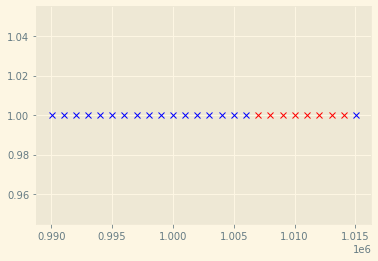

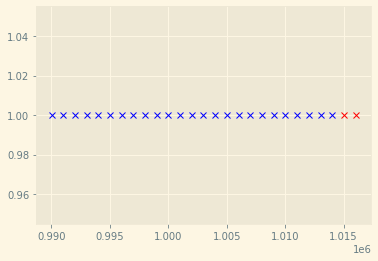

In [39]:
for gal in galaxies[1:3]:
 plt.plot(train[train.galaxy == gal]['galactic year'], np.ones(len(train[train.galaxy == gal]['galactic year'])), 'bx')
 plt.plot(test[test.galaxy == gal]['galactic year'], np.ones(len(test[test.galaxy == gal]['galactic year'])), 'rx')
 plt.show()

## We start by replacing the missing values by the last observed target for the galaxy. 

**We also added financial time series indicators, hoping they could give an idea of the trend of the target and its relation with the trends of the features**


In [40]:
test_bis=test.copy()
test_bis['y']=np.full(len(test),np.nan)

dataset_bis=pd.concat((train,test_bis),axis=0)
dataset_bis=dataset_bis.sort_values('galactic year')
dataset_bis=dataset_bis[['galaxy','galactic year','y']]

In [41]:

dict_y={}
for gal in galaxies:
    dict_y[gal]=dataset_bis[dataset_bis.galaxy==gal]
    dict_y[gal]['last_y']=(dict_y[gal]['y'].shift()).fillna(method='ffill')
    dict_y[gal]['next_y']=(dict_y[gal]['y'].shift(-1)).fillna(method='bfill')
    dict_y[gal]['next_y_2']=(dict_y[gal]['next_y'].shift(-1))
    dict_y[gal]['next_y_3']=(dict_y[gal]['next_y_2'].shift(-1))
    dict_y[gal]['last_likely']=np.log(dict_y[gal]['y'].shift()+0.01)

    diff = dict_y[gal]['last_y'].diff(1)
    up, down = diff.copy(), diff.copy()
    diff[up < 0] = 0
    diff[up > 0] = 1
    dict_y[gal]['last_y_psy'] = sma(diff,4)
    bb = ta.volatility.BollingerBands(dict_y[gal]['last_y'],n=6)
    dict_y[gal]['last_y_bb_%b'] = bb.bollinger_pband()
    dict_y[gal]['last_y_bb_bw'] = bb.bollinger_wband()
    dict_y[gal]['last_y_MACD'] = ta.trend.macd(dict_y[gal]['last_y'], n_slow=5, n_fast=2)
    Zscore=(dict_y[gal]['last_y']-sma(dict_y[gal]['last_y'],5))/dict_y[gal]['last_y'].rolling(5).std()
    dict_y[gal]['last_y_Zscore']=Zscore
    dict_y[gal]['last_likely_ema_4']=ema(dict_y[gal]['last_likely'],4,True).fillna(0)
    dict_y[gal]['last_likely_ema_6']=ema(dict_y[gal]['last_likely'],6,True).fillna(0)
    dict_y[gal]['last_y_ema_4']=ema(dict_y[gal]['last_y'],4,True).fillna(0)
    dict_y[gal]['last_y_ema_6']=ema(dict_y[gal]['last_y'],6,True).fillna(0)
    dict_y[gal]['last_y_ema_3']=ema(dict_y[gal]['last_y'],3,True).fillna(0)
    dict_y[gal]['time_diff']=dict_y[gal]['galactic year'].diff()
    dict_y[gal]['last_y_max']=dict_y[gal]['last_y'].rolling(5).max()
    dict_y[gal]['last_y_min']=dict_y[gal]['last_y'].rolling(5).min()
    #William %R
    wri = ta.momentum.WilliamsRIndicator(high=dict_y[gal]['last_y_max'],low=dict_y[gal]['last_y_min'],close=dict_y[gal]['last_y'],lbp=6)
    dict_y[gal]['last_y_WilliamsR'] = wri.wr()
    #Relative momentum index
    diff = dict_y[gal]['last_y'].diff(1)
    up = diff.where(diff > 0, 0.0)
    dn = -diff.where(diff < 0, 0.0)
    smaup = ta.utils.sma(up,6)
    smadn = ta.utils.sma(dn,6)
    rmi = (smaup/(smaup+smadn))*100
    dict_y[gal]['last_y_RMI'] = rmi
    #stochastic oscillators
    stochD = ta.momentum.StochasticOscillator(dict_y[gal]['last_y_max'],dict_y[gal]['last_y_min'],dict_y[gal]['last_y'], n=4, d_n=4)
    dict_y[gal]['last_y_stochK'] = stochD.stoch()
    dict_y[gal]['last_y_stochD'] = stochD.stoch_signal()
    #Average True Range
    atr = ta.volatility.AverageTrueRange(dict_y[gal]['last_y_max'],dict_y[gal]['last_y_min'],dict_y[gal]['last_y'],5)
    dict_y[gal]['last_y_ATR'] = atr.average_true_range()
    dict_y[gal]['last_y_CCI'] = ta.trend.cci(dict_y[gal]['last_y_max'],dict_y[gal]['last_y_min'],dict_y[gal]['last_y'], n=6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [42]:
y_features=['last_y','last_y_ema_4','last_likely','last_y_ema_6','last_y_ema_3','time_diff','last_y_max','last_y_min','last_likely_ema_4','last_likely_ema_6','last_y_bb_bw','last_y_bb_%b','last_y_MACD','last_y_Zscore','last_y_psy','last_y_WilliamsR','last_y_RMI','last_y_stochK','last_y_stochD','last_y_ATR','last_y_CCI']


In [43]:
alo=[]
for i in range(len(train)):
    gal=train.galaxy.iloc[i]
    year=train['galactic year'].iloc[i]
    past_data=dataset_years[dataset_years['galactic year']==year]
    wili=past_data[past_data.galaxy==gal]
    az=dict_y[gal][y_features][dict_y[gal]['galactic year']==year]
    wili=pd.concat((wili,az),axis=1)
    alo.append(wili)

X_train=pd.concat(alo,axis=0)

In [ ]:

model = xgb.XGBRegressor(colsample_bytree=0.3,
                 gamma=0,       
                 max_depth=5,
                 min_child_weight=2.,
                 n_estimators=222,                                                                    
                 
                 subsample=0.9,objective='reg:squarederror')

cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=5)

scores = -1*cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")
print(scores)
print(np.mean(scores))


[0.00494763 0.00792982 0.00777075 0.00857775 0.01120205]
0.008085600480224905


**The score improved a bit**

In [44]:
model = xgb.XGBRegressor(colsample_bytree=0.3,
                 gamma=0,       
                 max_depth=5,
                 min_child_weight=2.,
                 n_estimators=222,                                                                    
                 
                 subsample=0.9,objective='reg:squarederror')
model.fit(X_train,  y_train)

feature_imp = pd.Series(model.feature_importances_,index=list(X_train.columns)).sort_values(ascending=False)
feature_imp.head(10)

idh1_fut_cumax                                           0.285467
Life_expectancy_index_fut_cumax                          0.168322
Intergalactic Development Index (IDI), Rank_fut_cumax    0.130925
last_y_ema_4                                             0.066951
last_y_ema_3                                             0.051732
last_y_ema_6                                             0.028177
Life_expectancy_index_cumin                              0.020666
Gross capital formation (% of GGP)_3                     0.018716
last_y_max                                               0.018191
Share of seats in senate (% held by female)_3            0.017855
dtype: float32

We could stop here. But since the features related to past target values are not accurate ( due to the missing values) . **We use the prediction from this first model to reconstruct the target values to more accurate values**

In [45]:

model = RandomForestRegressor(max_depth=10, n_estimators=200)
model.fit(X_train[list(feature_imp.head(80).index)].fillna(0), np.log(y_train.fillna(0)))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

We have trained a **Random forest using the best 80 features from Xgboost** . 
We will now evaluate on each data points and **update the y based features at every step **, so the latter datapoints benefit from the improved y features.
We will repeat this 3 times 


In [46]:
preds=[]
for i in range(len(test)):
    gal=test.galaxy.iloc[i]
    year=test['galactic year'].iloc[i]
    past_data=dataset_years[dataset_years['galactic year']==year].copy()
    wili=past_data[past_data.galaxy==gal].copy()
    di=dict_y[gal].copy()
    az=di.loc[dict_y[gal]['galactic year']==year,y_features]
    wili=pd.concat((wili,az),axis=1).copy()
    a=wili[list(feature_imp.head(80).index)].fillna(0).copy()
    predi=np.exp(model.predict(a)[0])
    preds.append(predi)
    di.loc[di['galactic year']==year,'y']=predi   
    di.loc[di['galactic year']==year,'y']=predi
    di['last_y']=di['y'].shift().copy()
    di['next_y']=(di['y'].shift(-1)).fillna(method='bfill').copy()
    di['next_y_2']=(di['next_y'].shift(-1)).copy()
    di['next_y_3']=(di['next_y_2'].shift(-1)).copy()
    di['last_likely']=np.log(di['y'].shift()+0.01).copy()

    diff = di['last_y'].diff(1).copy()
    up, down = diff.copy(), diff.copy()
    diff[up < 0] = 0
    diff[up > 0] = 1
    di['last_y_psy'] = sma(diff,4).copy()
    bb = ta.volatility.BollingerBands(di['last_y'],n=6)
    di['last_y_bb_%b'] = bb.bollinger_pband().copy()
    di['last_y_bb_bw'] = bb.bollinger_wband().copy()
    
    di['last_y_MACD'] = ta.trend.macd(di['last_y'], n_slow=5, n_fast=2).copy()
    Zscore=(di['last_y']-sma(di['last_y'],5))/di['last_y'].rolling(5).std().copy()
    di['last_y_Zscore']=Zscore.copy()
    
    
    di['last_likely_ema_4']=ema(di['last_likely'],4,True).fillna(0).copy()
    di['last_likely_ema_6']=ema(di['last_likely'],6,True).fillna(0).copy()
    di['last_y_ema_4']=ema(di['last_y'],4,True).fillna(0).copy()
    di['last_y_ema_6']=ema(di['last_y'],6,True).fillna(0).copy()
    di['last_y_ema_3']=ema(di['last_y'],3,True).fillna(0).copy()
    di['time_diff']=di['galactic year'].diff().copy()
    di['last_y_max']=di['last_y'].rolling(5).max().copy()
    di['last_y_min']=di['last_y'].rolling(5).min().copy()
    
    #William %R
    wri = ta.momentum.WilliamsRIndicator(high=di['last_y_max'],low=di['last_y_min'],close=di['last_y'],lbp=6)
    di['last_y_WilliamsR'] = wri.wr().copy()

    #Relative momentum index
    diff = di['last_y'].diff(1).copy()
    up = diff.where(diff > 0, 0.0)
    dn = -diff.where(diff < 0, 0.0)
    smaup = ta.utils.sma(up,6)
    smadn = ta.utils.sma(dn,6)
    rmi = (smaup/(smaup+smadn))*100
    di['last_y_RMI'] = rmi.copy()


    #stochastic oscillators
    stochD = ta.momentum.StochasticOscillator(di['last_y_max'],di['last_y_min'],di['last_y'], n=4, d_n=4)
    di['last_y_stochK'] = stochD.stoch().copy()
    di['last_y_stochD'] = stochD.stoch_signal().copy()

    #Average True Range
    atr = ta.volatility.AverageTrueRange(di['last_y_max'],di['last_y_min'],di['last_y'],5)
    di['last_y_ATR'] = atr.average_true_range().copy()
    di['last_y_CCI'] = ta.trend.cci(di['last_y_max'],di['last_y_min'],di['last_y'], n=6).copy()
    dict_y[gal]=di.copy()

In [47]:
predi1=pd.DataFrame(preds)

In [48]:
alo=[]
for i in range(len(train)):
    gal=train.galaxy.iloc[i]
    year=train['galactic year'].iloc[i]
    past_data=dataset_years[dataset_years['galactic year']==year]
    wili=past_data[past_data.galaxy==gal]
    az=dict_y[gal][y_features][dict_y[gal]['galactic year']==year]
    wili=pd.concat((wili,az),axis=1)
    alo.append(wili)

X_train=pd.concat(alo,axis=0)

# Refit the model on the improved last_y features

In [49]:

model = RandomForestRegressor(max_depth=10, n_estimators=200)
model.fit(X_train[list(feature_imp.head(100).index)].fillna(0), np.log(y_train.fillna(0)))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# New test Evaluation and update

In [50]:
preds2=[]
for i in range(len(test)):
    gal=test.galaxy.iloc[i]
    year=test['galactic year'].iloc[i]
    past_data=dataset_years[dataset_years['galactic year']==year].copy()
    wili=past_data[past_data.galaxy==gal].copy()
    di=dict_y[gal].copy()
    az=di.loc[dict_y[gal]['galactic year']==year,y_features]
    wili=pd.concat((wili,az),axis=1).copy()
    a=wili[list(feature_imp.head(100).index)].fillna(0).copy()
    
    predi=np.exp(model.predict(a)[0])
    
    preds2.append(predi)
    
    di.loc[di['galactic year']==year,'y']=predi
    
    
    di.loc[di['galactic year']==year,'y']=predi
    di['last_y']=di['y'].shift().copy()
    di['next_y']=(di['y'].shift(-1)).fillna(method='bfill').copy()
    di['next_y_2']=(di['next_y'].shift(-1)).copy()
    di['next_y_3']=(di['next_y_2'].shift(-1)).copy()
    di['last_likely']=np.log(di['y'].shift()+0.01).copy()

    diff = di['last_y'].diff(1).copy()
    up, down = diff.copy(), diff.copy()
    diff[up < 0] = 0
    diff[up > 0] = 1
    di['last_y_psy'] = sma(diff,4).copy()
    bb = ta.volatility.BollingerBands(di['last_y'],n=6)
    di['last_y_bb_%b'] = bb.bollinger_pband().copy()
    di['last_y_bb_bw'] = bb.bollinger_wband().copy()
    
    di['last_y_MACD'] = ta.trend.macd(di['last_y'], n_slow=5, n_fast=2).copy()
    Zscore=(di['last_y']-sma(di['last_y'],5))/di['last_y'].rolling(5).std().copy()
    di['last_y_Zscore']=Zscore.copy()
    
    
    di['last_likely_ema_4']=ema(di['last_likely'],4,True).fillna(0).copy()
    di['last_likely_ema_6']=ema(di['last_likely'],6,True).fillna(0).copy()
    di['last_y_ema_4']=ema(di['last_y'],4,True).fillna(0).copy()
    di['last_y_ema_6']=ema(di['last_y'],6,True).fillna(0).copy()
    di['last_y_ema_3']=ema(di['last_y'],3,True).fillna(0).copy()
    di['time_diff']=di['galactic year'].diff().copy()
    di['last_y_max']=di['last_y'].rolling(5).max().copy()
    di['last_y_min']=di['last_y'].rolling(5).min().copy()
    
    #William %R
    wri = ta.momentum.WilliamsRIndicator(high=di['last_y_max'],low=di['last_y_min'],close=di['last_y'],lbp=6)
    di['last_y_WilliamsR'] = wri.wr().copy()

    #Relative momentum index
    diff = di['last_y'].diff(1).copy()
    up = diff.where(diff > 0, 0.0)
    dn = -diff.where(diff < 0, 0.0)
    smaup = ta.utils.sma(up,6)
    smadn = ta.utils.sma(dn,6)
    rmi = (smaup/(smaup+smadn))*100
    di['last_y_RMI'] = rmi.copy()


    #stochastic oscillators
    stochD = ta.momentum.StochasticOscillator(di['last_y_max'],di['last_y_min'],di['last_y'], n=4, d_n=4)
    di['last_y_stochK'] = stochD.stoch().copy()
    di['last_y_stochD'] = stochD.stoch_signal().copy()

    #Average True Range
    atr = ta.volatility.AverageTrueRange(di['last_y_max'],di['last_y_min'],di['last_y'],5)
    di['last_y_ATR'] = atr.average_true_range().copy()


    di['last_y_CCI'] = ta.trend.cci(di['last_y_max'],di['last_y_min'],di['last_y'], n=6).copy()
    dict_y[gal]=di.copy()


In [51]:
predi2=pd.DataFrame(preds2)

In [52]:
alo=[]
for i in range(len(train)):
    gal=train.galaxy.iloc[i]
    year=train['galactic year'].iloc[i]
    past_data=dataset_years[dataset_years['galactic year']==year]
    wili=past_data[past_data.galaxy==gal]
    az=dict_y[gal][y_features][dict_y[gal]['galactic year']==year]
    wili=pd.concat((wili,az),axis=1)
    alo.append(wili)

X_train=pd.concat(alo,axis=0)

In [53]:

model = RandomForestRegressor(max_depth=10, n_estimators=200)
model.fit(X_train[list(feature_imp.head(80).index)].fillna(0), np.log(y_train.fillna(0)))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [54]:
preds3=[]
for i in range(len(test)):
    gal=test.galaxy.iloc[i]
    year=test['galactic year'].iloc[i]
    past_data=dataset_years[dataset_years['galactic year']==year].copy()
    wili=past_data[past_data.galaxy==gal].copy()
    di=dict_y[gal].copy()
    az=di.loc[dict_y[gal]['galactic year']==year,y_features]
    wili=pd.concat((wili,az),axis=1).copy()
    a=wili[list(feature_imp.head(80).index)].fillna(0).copy()
    
    predi=np.exp(model.predict(a)[0])
    
    preds3.append(predi)
    
    di.loc[di['galactic year']==year,'y']=predi
    
    
    di.loc[di['galactic year']==year,'y']=predi
    di['last_y']=di['y'].shift().copy()
    di['next_y']=(di['y'].shift(-1)).fillna(method='bfill').copy()
    di['next_y_2']=(di['next_y'].shift(-1)).copy()
    di['next_y_3']=(di['next_y_2'].shift(-1)).copy()
    di['last_likely']=np.log(di['y'].shift()+0.01).copy()

    diff = di['last_y'].diff(1).copy()
    up, down = diff.copy(), diff.copy()
    diff[up < 0] = 0
    diff[up > 0] = 1
    di['last_y_psy'] = sma(diff,4).copy()
    bb = ta.volatility.BollingerBands(di['last_y'],n=6)
    di['last_y_bb_%b'] = bb.bollinger_pband().copy()
    di['last_y_bb_bw'] = bb.bollinger_wband().copy()
    
    di['last_y_MACD'] = ta.trend.macd(di['last_y'], n_slow=5, n_fast=2).copy()
    Zscore=(di['last_y']-sma(di['last_y'],5))/di['last_y'].rolling(5).std().copy()
    di['last_y_Zscore']=Zscore.copy()
    
    
    di['last_likely_ema_4']=ema(di['last_likely'],4,True).fillna(0).copy()
    di['last_likely_ema_6']=ema(di['last_likely'],6,True).fillna(0).copy()
    di['last_y_ema_4']=ema(di['last_y'],4,True).fillna(0).copy()
    di['last_y_ema_6']=ema(di['last_y'],6,True).fillna(0).copy()
    di['last_y_ema_3']=ema(di['last_y'],3,True).fillna(0).copy()
    di['time_diff']=di['galactic year'].diff().copy()
    di['last_y_max']=di['last_y'].rolling(5).max().copy()
    di['last_y_min']=di['last_y'].rolling(5).min().copy()
    
    #William %R
    wri = ta.momentum.WilliamsRIndicator(high=di['last_y_max'],low=di['last_y_min'],close=di['last_y'],lbp=6)
    di['last_y_WilliamsR'] = wri.wr().copy()

    #Relative momentum index
    diff = di['last_y'].diff(1).copy()
    up = diff.where(diff > 0, 0.0)
    dn = -diff.where(diff < 0, 0.0)
    smaup = ta.utils.sma(up,6)
    smadn = ta.utils.sma(dn,6)
    rmi = (smaup/(smaup+smadn))*100
    di['last_y_RMI'] = rmi.copy()


    #stochastic oscillators
    stochD = ta.momentum.StochasticOscillator(di['last_y_max'],di['last_y_min'],di['last_y'], n=4, d_n=4)
    di['last_y_stochK'] = stochD.stoch().copy()
    di['last_y_stochD'] = stochD.stoch_signal().copy()

    #Average True Range
    atr = ta.volatility.AverageTrueRange(di['last_y_max'],di['last_y_min'],di['last_y'],5)
    di['last_y_ATR'] = atr.average_true_range().copy()


    di['last_y_CCI'] = ta.trend.cci(di['last_y_max'],di['last_y_min'],di['last_y'], n=6).copy()
    dict_y[gal]=di.copy()

    
    

    
    
    


We have completed the task 3 times and **believe the features are more accurate**. Of course the model will be influenced by the first bias since the features now lead to that value, it is also possible that the model slowly converges to the ideal prediction after every repetition. It did improve the lb score .
we can now train a model on **these possibly better features**

In [55]:
alo=[]
for i in range(len(train)):
    gal=train.galaxy.iloc[i]
    year=train['galactic year'].iloc[i]
    past_data=dataset_years[dataset_years['galactic year']==year]
    wili=past_data[past_data.galaxy==gal]
    az=dict_y[gal][y_features][dict_y[gal]['galactic year']==year]
    wili=pd.concat((wili,az),axis=1)
    alo.append(wili)

X_train=pd.concat(alo,axis=0)

In [56]:
alo=[]

for i in range(len(test)):
  gal=test.galaxy.iloc[i]
  year=test['galactic year'].iloc[i]
  past_data=dataset_years[dataset_years['galactic year']==year]
  wili=past_data[past_data.galaxy==gal]
  az=dict_y[gal][y_features][dict_y[gal]['galactic year']==year]
  wili=pd.concat((wili,az),axis=1)
  alo.append(wili)

X_test=pd.concat(alo,axis=0)

We train the random forest model on the **pot_increase**, because we want an **idea of the uncertainty of this variable for the latter optimisation **

In [57]:


model = RandomForestRegressor(max_depth=10, n_estimators=200)
model.fit( X_train[list(feature_imp.head(80).index)].fillna(0), np.log(y_train+0.01))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# We next retrieve the prediction from every tree as a measure of uncertainty of prediction 

In [58]:


results=pd.DataFrame()
i=0
for pred in model.estimators_:
    results[str(i)]=pred.predict(X_test[list(feature_imp.head(80).index)].fillna(0))
    i=i+1

In [59]:
results_bis=pd.DataFrame()
i=0
for pred in model.estimators_:
    results_bis[str(i)]=np.exp(results[str(i)])-0.01
    i=i+1

In [60]:
results_bis

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.041550,0.041496,0.041556,0.041910,0.041888,0.041599,0.041978,0.041716,0.041677,0.041753,0.041592,0.041394,0.041710,0.042317,0.041709,0.041571,0.041252,0.041831,0.041751,0.041504,0.041848,0.041618,0.041617,0.041620,0.041574,0.041474,0.041635,0.041450,0.041677,0.041529,0.041970,0.041849,0.041509,0.041749,0.041832,0.041702,0.040958,0.041577,0.041408,0.041231,...,0.041633,0.041727,0.041949,0.041670,0.041889,0.041217,0.042160,0.041759,0.041771,0.041619,0.041403,0.041660,0.041661,0.041648,0.041567,0.041585,0.041475,0.041652,0.041657,0.041647,0.042015,0.041872,0.041572,0.041643,0.041697,0.041677,0.041513,0.041433,0.041506,0.041626,0.041320,0.041207,0.041697,0.041567,0.041719,0.041681,0.041604,0.038537,0.041550,0.041569
1,0.037891,0.038086,0.040188,0.037982,0.038743,0.039374,0.038743,0.039262,0.039076,0.038744,0.038954,0.039993,0.038779,0.037845,0.039926,0.040247,0.038585,0.038598,0.038732,0.038943,0.037982,0.038006,0.037982,0.039624,0.038679,0.038749,0.038870,0.039035,0.038634,0.039080,0.039122,0.038604,0.038296,0.038509,0.038585,0.038892,0.037521,0.038671,0.038775,0.040144,...,0.039357,0.038812,0.038961,0.038056,0.038574,0.038872,0.038584,0.038865,0.040066,0.038204,0.038551,0.038932,0.037982,0.038763,0.038757,0.039174,0.039015,0.038691,0.039102,0.040569,0.039421,0.039276,0.039261,0.039123,0.038601,0.039598,0.038591,0.039743,0.039307,0.037521,0.038688,0.039333,0.037978,0.037982,0.038178,0.037521,0.038589,0.039075,0.038650,0.038674
2,0.037891,0.038086,0.037982,0.037982,0.038743,0.038375,0.038743,0.037982,0.038324,0.037982,0.038566,0.039118,0.038779,0.038589,0.038613,0.037946,0.038094,0.038598,0.038035,0.038943,0.037982,0.038731,0.037982,0.038863,0.038115,0.038066,0.038870,0.037954,0.038634,0.038080,0.038608,0.038129,0.038296,0.038509,0.037976,0.038424,0.038575,0.038108,0.038384,0.037982,...,0.039357,0.038087,0.038961,0.037542,0.038087,0.038872,0.037917,0.038322,0.038612,0.038756,0.038551,0.038932,0.037982,0.038763,0.038757,0.038319,0.038375,0.037964,0.029242,0.038681,0.038323,0.038087,0.037856,0.038375,0.038080,0.038087,0.038090,0.038322,0.039307,0.037521,0.038688,0.038613,0.038661,0.037982,0.038178,0.038936,0.038070,0.037955,0.038650,0.038674
3,0.038940,0.038700,0.040188,0.038537,0.038743,0.039374,0.038811,0.038800,0.039076,0.038744,0.037976,0.039118,0.038779,0.039260,0.038663,0.038666,0.038585,0.038598,0.038732,0.038943,0.039313,0.038874,0.038733,0.040009,0.039839,0.038749,0.039245,0.039638,0.037982,0.038971,0.039122,0.038604,0.038296,0.038954,0.038585,0.038424,0.039634,0.038545,0.038384,0.038782,...,0.040065,0.038812,0.038961,0.038056,0.038574,0.038872,0.038584,0.038868,0.038144,0.038204,0.037521,0.038932,0.038856,0.038763,0.038757,0.039174,0.039015,0.038555,0.038322,0.039435,0.039421,0.038597,0.039261,0.039123,0.038601,0.038375,0.040084,0.039101,0.038938,0.038557,0.038688,0.039333,0.039023,0.038517,0.038837,0.039444,0.038589,0.038324,0.038650,0.038834
4,0.024168,0.023954,0.024187,0.022704,0.023010,0.025876,0.029513,0.026720,0.029513,0.029281,0.022962,0.022204,0.029513,0.029513,0.020226,0.023422,0.026720,0.024301,0.023662,0.023305,0.022365,0.024004,0.029513,0.023807,0.022979,0.022374,0.020226,0.025877,0.022086,0.020226,0.023601,0.022966,0.021057,0.024532,0.022966,0.029513,0.022955,0.025913,0.020226,0.022204,...,0.021664,0.022923,0.023217,0.025292,0.025900,0.022688,0.025913,0.024003,0.023083,0.023049,0.023095,0.020226,0.023099,0.020226,0.024205,0.029513,0.025913,0.029513,0.025913,0.022441,0.025913,0.022222,0.029513,0.022324,0.025876,0.023264,0.024038,0.022942,0.023264,0.029700,0.022962,0.029513,0.029513,0.029513,0.025876,0.023141,0.020226,0.022204,0.023371,0.022417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Visualisation of the upper and lower confidence regions of the sorted mean preds. 

In [62]:
a=pd.DataFrame()
a['upper']=results_bis.mean(axis=1)+results_bis.std(axis=1)
a['down']=results_bis.mean(axis=1)-results_bis.std(axis=1)
a['moyenne']=results_bis.mean(axis=1)

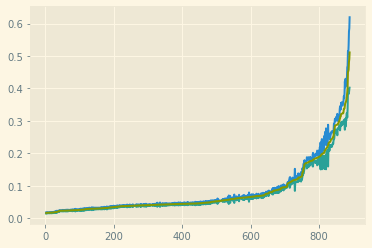

In [63]:
cc=a.sort_values('moyenne').reset_index(drop=True)
plt.plot(cc,label=cc.columns)


# Construction of allocation: 
For every estimator prediction, we rank the prediction in increasing manner :
We give the first 500 an allocation of 100.  and the rest zeros. It almost always satisfies the constraint. Of course every mistake in ranking leads to huge loss. So we hope that averaging accross the 200 tree prediction of Random Forest We will have **an allocation that accounts for the uncertainty of our predictions** . 

We later chose to allocate in a linear fashion between  ranks 350 and 650, as this manual manipulation seemed to account better for the uncertainty. 


In [64]:
   
allocation=pd.DataFrame()
for col in results.columns:
    bruh=pd.DataFrame(results[col].sort_values())
    bruh['allocation']=0.
    bruh.iloc[0:350,1]=100.
    bruh.iloc[350:650,1]=[99.833-i*(100/300) for i in range(300)]
    bruh=bruh.sort_index()
    allocation[col]=bruh['allocation']

In [65]:
allocation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.166333,100.000000,100.000000,99.166333,100.000000,100.000000,100.000,100.000000,100.000000,97.499667,100.000000,100.000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,99.166333,100.000000,100.000000,100.000000,100.000000,100.000000,98.166333,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,96.833000,100.000000,100.0,100.000000,100.000,100.000000,99.833000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000
1,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000
2,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000
3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000
4,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000,100.000,100.000000,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000

Checking Constraint for mean allocation

In [66]:
alloo=allocation.mean(axis=1)
expec=test['existence expectancy index']
low=pd.DataFrame()
low['islow']=expec
low['islow']=0.
low['islow'][expec<0.7]=1.
(allocation.mean(axis=1)*low.islow).sum()

6458.634651666666

In [67]:
sub=pd.DataFrame()
sub['index']=test.index
sub['pred']=results_bis.mean(axis=1)
sub['opt_pred']=alloo
sub.to_csv('submission.csv',index=False)